In [33]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.cort_processor import *

from src.plotter import *
from src.filters import *
import math
import pickle
import scipy
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import cm
from scipy import signal
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import tdt 
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, iirnotch, filtfilt, resample, hilbert, welch
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
from scipy.io import savemat
from src.phase_decoder_support import *
from src.neural_analysis import *
from src.wiener_filter import *
from src.folder_handler import *
from src.tdt_support import *
from src.decoders import *
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
rollie1129 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/rollie/1129')
rollie1129.process(clear_storage = False)

read from t=0s to t=371.88s
read from t=0s to t=352.3s


(array([[ 20.,  80.,  20., ...,  40.,  20.,  20.],
        [ 20.,  40.,   0., ...,  20.,  20.,  60.],
        [  0.,  40.,  40., ..., 140.,  20.,  40.],
        ...,
        [ 20.,   0.,   0., ...,  20.,  20.,   0.],
        [ 40.,  40.,   0., ...,  20.,  40.,  80.],
        [  0.,  40.,   0., ...,  20.,   0.,   0.]]),
 array([[167.48464387,  63.85915525,  85.57627118, ...,  61.62516639,
          82.02233546, 160.45151816],
        [162.68903079,  67.16539274,  79.07084519, ...,  59.99230052,
          76.71208209, 165.0244428 ],
        [163.31619854,  55.54741612,  84.60433203, ...,  64.38591679,
          82.54450781, 163.78877682],
        ...,
        [147.91989055,  54.29923447, 103.29290928, ...,  74.90590892,
          96.67447058, 159.89321414],
        [144.20502153,  54.43811062, 104.45613898, ...,  75.77255941,
          98.28704118, 158.96151146],
        [142.76760199,  54.96163038, 106.93983068, ...,  76.36840837,
         106.24960909, 164.28462118]]))

In [3]:
rollie1129.kin_data[1]['fnum']

array([ 5000,  5001,  5002, ..., 67597, 67598, 67599])

In [4]:
rollie1129.kin_data[0]['bodyparts']

['toe',
 'MTP',
 'ankle',
 'knee',
 'pelvis bottom',
 'hip',
 'pelvis top',
 'finger',
 'knuckle',
 'wrist',
 'elbow',
 'shoulder',
 'scapula',
 'x1',
 'x2',
 'y1',
 'y2']

In [5]:
rollie1129.kin_data[0]['coords'].shape

(66000, 17, 3)

In [6]:
wrist_y = rollie1129.kin_data[0]['coords'][:, 9, 1]
scapula_y = rollie1129.kin_data[0]['coords'][:, 12, 1]
relative_y = wrist_y - scapula_y 
y_min = np.min(relative_y)
rel_y = relative_y - y_min
wrist_x = rollie1129.kin_data[0]['coords'][:, 9, 0]
knuckle_x = rollie1129.kin_data[0]['coords'][:, 8, 0]
finger_x = rollie1129.kin_data[0]['coords'][:, 7, 0]
shoulder_x = rollie1129.kin_data[0]['coords'][:, 11, 0]
relative_x = shoulder_x - wrist_x
min_x = np.min(relative_x)
rel_x = relative_x - min_x
relative_x2 = shoulder_x - knuckle_x
min_x2 = np.min(relative_x2)
rel_x2 = relative_x2 - min_x2
relative_x3 = shoulder_x - finger_x
min_x3 = np.min(relative_x3)
rel_x3 = relative_x3 - min_x3
fore_angle = rollie1129.kin_data[0]['angles'][:, 7]
fnum = rollie1129.kin_data[0]['fnum']

In [7]:
dy = np.diff(rel_y)
dx = np.diff(rel_x)
dt = 1/200
dydt_tmp = dy/dt
dxdt_tmp = dx/dt
ddy = np.diff(rel_y, 2)
ddx = np.diff(rel_x, 2)
ddyddt_tmp = ddy/(dt**2)
ddxddt_tmp = ddx/(dt**2)
dddy = np.diff(rel_y, 3)
dddydddt_tmp = dddy/(dt**3)
dddx = np.diff(rel_x, 3)
dddxdddt_tmp = dddx/(dt**3)


dtheta = np.diff(fore_angle)
dthetadt_tmp = dtheta/dt
ddtheta = np.diff(fore_angle, 2)
ddthetaddt_tmp = ddtheta/(dt**2)
dddtheta = np.diff(fore_angle, 3)
dddthetadddt_tmp = dddtheta/(dt**3)




dddxdddt = lowpass_filt(dddxdddt_tmp, 10, 200)
ddxddt = lowpass_filt(ddxddt_tmp, 10, 200)
dxdt = lowpass_filt(dxdt_tmp, 10, 200)

dddydddt = lowpass_filt(dddydddt_tmp, 10, 200)
ddyddt = lowpass_filt(ddyddt_tmp, 10, 200)
dydt = lowpass_filt(dydt_tmp, 10, 200)

dddthetadddt = lowpass_filt(dddthetadddt_tmp, 10, 200)
ddthetaddt = lowpass_filt(ddthetaddt_tmp, 10, 200)
dthetadt = lowpass_filt(dthetadt_tmp, 10, 200)

dddthetadddt = np.append(dddthetadddt, [0,0,0])
ddthetaddt = np.append(ddthetaddt, [0,0])
dthetadt = np.append(dthetadt, [0])

dddxdddt = np.append(dddxdddt, [0,0,0])
ddxddt = np.append(ddxddt, [0,0])
dxdt = np.append(dxdt, [0])

dddydddt = np.append(dddydddt, [0,0,0])
ddyddt = np.append(ddyddt, [0,0])
dydt = np.append(dydt, [0])

In [8]:
peaks_theta, _ = spicy.signal.find_peaks(fore_angle, wlen= 600, prominence = 3, distance = 100, height = 0.4*np.mean(fore_angle))    
neg_peaks_theta, _ = spicy.signal.find_peaks(-(fore_angle), wlen= 600, prominence = 3, distance = 100, height = np.mean(fore_angle))    
peaks_dthetadt_plus, _ = spicy.signal.find_peaks(dthetadt, prominence=3, distance= 100)    
peaks_dthetadt_minus, _ = spicy.signal.find_peaks(-(dthetadt), prominence=3, distance= 100)    
peaks_ddthetaddt_plus, _ = spicy.signal.find_peaks(ddthetaddt, prominence=3, distance= 100)    
peaks_ddthetaddt_minus, _ = spicy.signal.find_peaks(-(ddthetaddt), prominence=3, distance= 100)    
peaks_dddthetadddt_minus, _ = spicy.signal.find_peaks(-(dddthetadddt), distance= 50, prominence = 5, height = -0.02*np.min(dddthetadddt))    


peaks_relx, _ = spicy.signal.find_peaks(rel_x, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.mean(rel_x))
neg_peaks_relx, _ = spicy.signal.find_peaks(-(rel_x), wlen= 600, prominence = 3, distance = 50, height = -0.8*np.mean(rel_x))
peaks_dxdt_plus, _ = spicy.signal.find_peaks(dxdt, prominence=3, distance= 50, height = 0.2*np.max(dxdt))    
peaks_dxdt_minus, _ = spicy.signal.find_peaks(-(dxdt), prominence=3, distance= 50, height = -0.2*np.min(dxdt))    
peaks_ddxddt_plus, _ = spicy.signal.find_peaks(ddxddt, prominence=3, distance= 50, height = 0.2*np.max(ddxddt))    
peaks_ddxddt_minus, _ = spicy.signal.find_peaks(-(ddxddt), prominence=3, distance= 50, height = -0.2*np.min(ddxddt))    
peaks_dddxdddt_minus, _ = spicy.signal.find_peaks(-(dddxdddt), distance= 50, threshold =10,prominence = 5, height = -0.2*np.min(dddxdddt))    

peaks_rely, _ = spicy.signal.find_peaks(rel_y, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.mean(rel_y))
neg_peaks_rely, _ = spicy.signal.find_peaks(-(rel_y), wlen= 600, prominence = 3, distance = 50, height = -np.mean(rel_y))
peaks_dydt_plus, _ = spicy.signal.find_peaks(dydt, prominence=3, distance= 50, height = 0.2*np.max(dydt))    
peaks_dydt_minus, _ = spicy.signal.find_peaks(-(dydt), prominence=3, distance= 50, height = 0.2*np.min(dydt))    
peaks_ddyddt_plus, _ = spicy.signal.find_peaks(ddyddt, prominence=3, distance= 50, height = 0.2*np.max(ddyddt))    
peaks_ddyddt_minus, _ = spicy.signal.find_peaks(-(ddyddt), prominence=3, distance= 50, height = -0.2*np.min(ddyddt))    
peaks_dddydddt_minus, _ = spicy.signal.find_peaks(-(dddydddt), distance= 50, threshold =10,prominence = 5, height = -0.2*np.min(dddydddt))   

In [9]:
np.max(rel_x)

85.53754518942196

In [10]:
neg_peaks_relx.shape

(503,)

In [11]:
peaks_dydt_minus.shape

(674,)

In [89]:
index_list = [0,1,2,3]
print(len(index_list) % 2)

0


In [139]:
#############EVERYTHING HERE HAS ACCESS TO SEL

# def relative_x(self, 'mark_name'):
def relative_x_tmp(bodypart):
    if bodypart == 'shoulder':
        print('invalid selection')
        return None
    wrist_x = rollie1129.marker_position(bodypart, 0)
    shoulder_x = rollie1129.marker_position('shoulder', 0)
    relative_x = shoulder_x - wrist_x
    min_x = np.min(relative_x)
    rel_x = relative_x - min_x
    return rel_x


########EVERYTHING BELOW THIS POINT IS IN A SEPARATE IPYNB

def replace_with_null(arr):
    i = 0
    while i < len(arr):
        if arr[i] == 0:
            j = i
            while j < len(arr) and arr[j] == 0:
                j += 1
            if j - i >= 30:
                for k in range(i, j):
                    arr[k] = None
            i = j
        else:
            i += 1
    return arr

def replace_null(arr):
    for i in range(arr.shape[0]):
        if np.isnan(arr[i]) == True:
            arr[i] = 0
    return arr

def x_swing_binary(kin_signal):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt_tmp = dk/dt
    dddk = np.diff(kin_signal, 3)
    dddkdddt_tmp = dddk/(dt**3)
    dddkdddt = lowpass_filt(dddkdddt_tmp, 10, 200)
    dkdt = lowpass_filt(dkdt_tmp, 10, 200)
    dkdt = np.append(dkdt, [0])
    dddkdddt = np.append(dddkdddt, [0,0,0])
    kin_peaks, _ = spicy.signal.find_peaks(kin_signal, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.mean(kin_signal))
    dddkdddt_valleys, _ = spicy.signal.find_peaks(dthetadt, prominence=3, distance= 100)    
    bdkdt = np.zeros((dkdt.shape[0]))
    for i in range(len(dkdt)):
        if (dkdt[i]) >= np.max(dkdt)*0.05:
            bdkdt[i] = 1
    for i in range(1,len(bdkdt)-1,1):
        if (bdkdt[i]) == 1:
            if (bdkdt[i+1] == 0) and (bdkdt[i-1] == 0):
                bdkdt[i] = 0
    for i in range(1,len(bdkdt)-1,1):
        if (bdkdt[i]) == 0:
            if (bdkdt[i+1] == 1) and (bdkdt[i-1] == 1):
                bdkdt[i] = 1
    for i in range(0,len(bdkdt)-50,1):
        if (bdkdt[i] == 1) and (bdkdt[i-1] == 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while bdkdt[i+1+tick] == 1:
                index_list.append(i+1+tick)
                tick = tick+1
            if any(val in kin_peaks for val in index_list) or any(val in dddkdddt_valleys for val in index_list):
                if any(val in kin_peaks for val in index_list) and any(val in dddkdddt_valleys for val in index_list):
                    continue
                else:
                    for index in index_list:
                        bdkdt[index] = 0.5
            else:
                for index in index_list:
                    bdkdt[index] = 0  
    return bdkdt

    
def x_stance_binary(kin_signal):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt_tmp = dk/dt
    dkdt = lowpass_filt(dkdt_tmp, 10, 200)
    dkdt = np.append(dkdt, [0])
    kin_valleys, _ = spicy.signal.find_peaks(-(kin_signal), wlen= 600, prominence = 3, distance = 50, height = -0.8*np.mean(kin_signal))
    dkdt_valleys, _ = spicy.signal.find_peaks(-(dkdt), prominence=3, distance= 50, height = -0.2*np.min(dkdt))
    qdkdt = np.zeros((dkdt.shape[0]))
    for i in range(len(dkdt)):
        if (dkdt[i]) <= np.min(dkdt)*0.05:
            qdkdt[i] = -1
    for i in range(1,len(qdkdt)-1,1):
        if (qdkdt[i]) == -1:
            if (qdkdt[i+1] == 0) and (qdkdt[i-1] == 0):
                qdkdt[i] = 0
    for i in range(1,len(qdkdt)-1,1):
        if (qdkdt[i]) == 0:
            if (qdkdt[i+1] == -1) and (qdkdt[i-1] == -1):
                qdkdt[i] = -1
    for i in range(0,len(qdkdt)-50,1):
        if (qdkdt[i] == -1) and (qdkdt[i-1] == 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while qdkdt[i+1+tick] == -1:
                index_list.append(i+1+tick)
                tick = tick+1
            if any(val in kin_valleys for val in index_list) or any(val in dkdt_valleys for val in index_list):
                if any(val in kin_valleys for val in index_list) and any(val in dkdt_valleys for val in index_list):
                    continue
                else:
                    for index in index_list:
                        qdkdt[index] = -0.5
            else:
                for index in index_list:
                    qdkdt[index] = 0
    return qdkdt

def stance_swing_trinary(sss):
               
    sss_null = replace_with_null(sss)
    adjustments1 = 0 
    adjustments2 = 0 

    adjustments3 = 0 
    for i in range(10,len(sss_null)-50,1):
        if (sss_null[i] == 0) and (sss_null[i-1] != 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while sss_null[i+1+tick] == 0:
                index_list.append(i+1+tick)
                tick = tick+1
            if sss_null[i-1] is not None and sss_null[i+1+tick] is not None:
                if sss_null[i-1] == sss_null[i+1+tick]:
                    adjustments1 = adjustments1+1
                    for index in index_list:
                        sss_null[index] = sss_null[i-1]
                elif len(index_list) > 1:
                    adjustments2 = adjustments2 +1
                    if len(index_list) % 2 == 1:
                        mid = len(index_list)//2
                        for index in index_list[:mid]:
                            sss_null[index] = sss_null[i-1]
                        for index in index_list[mid+1:]:
                            sss_null[index] = sss_null[i+tick+1]
                    elif len(index_list) % 2 == 0:
                        mid = len(index_list)//2
                        for index in index_list[:mid]:
                            sss_null[index] = sss_null[i-1]
                        for index in index_list[mid:]:
                            sss_null[index] = sss_null[i+tick+1]
    for i in range(1,len(sss_null)-1,1):
        if (sss_null[i] == 0):
            if sss_null[i-1] is not None and sss_null[i+1] is not None:
                if (sss_null[i-1] != 0) and (sss_null[i+1] != 0):
                    if random.random() <= 0.5:
                        sss_null[i] = sss_null[i-1]
                    else:
                        sss_null[i] = sss_null[i+1]
                adjustments3 = adjustments3+1
    np.array(sss_null)
    sstrinary = replace_null(sss_null)
    print(adjustments1)
    print(adjustments2)

    print(adjustments3)

    return sstrinary

def x_trinary_phase(kin_signal):
    swing_ind = x_swing_binary(kin_signal)
    stance_ind = x_stance_binary(kin_signal)
    sss = np.sum((swing_ind, stance_ind), axis = 0) 
    trinary = stance_swing_trinary(sss)
    return trinary

def trine_trinary_voting(trinary1, trinary2, trinary3):
    trinary0 = np.zeros((trinary1.shape[0]))
    for i in range(trinary1.shape[0]):
        if trinary1[i] == trinary2[i] or trinary1[i] == trinary3[i]:
            trinary0[i] = trinary1[i]
        elif trinary2[i] == trinary3[i]:
            trinary0[i] = trinary2[i]
        else:
            continue
    counter = 0
    for i in range(1,trinary0.shape[0]-1,1):
        if (trinary0[i] != trinary0[i-1]) and (trinary0[i] != trinary0[i+1]) and (trinary0[i+1] == trinary0[i-1]):
            trinary0[i] = trinary0[i-1]
            counter = counter+1
    print('consensus smoothing counter:',counter)
    return trinary0


In [140]:
stance_test = x_stance_binary(rel_x)
swing_test = x_swing_binary(rel_x)

In [141]:
# insanity_check = theta_trinary_phase(fore_angle)

wrist_phase = x_trinary_phase(rel_x)
knuckle_phase = x_trinary_phase(rel_x2)
finger_phase = x_trinary_phase(rel_x3)

12
839
417
12
806
431
9
787
424


In [142]:
sum_phase_tmp = np.sum((wrist_phase, knuckle_phase, finger_phase), axis=0)

print(len(sum_phase))

66000


In [147]:
sum_phase = sum_phase_tmp.copy()
for i in range(1,len(sum_phase)-1,1):
    if sum_phase[i] > 1.5 and sum_phase[i] < 3:
        index_list = []
        index_list.append(i)
        tick = 0
        while sum_phase[i+1+tick] == sum_phase[i]:
            index_list.append(i+1+tick)
            tick = tick+1
        if sum_phase[i-1] >= 1.5 or sum_phase[i+1+tick] >= 1.5:
            for index in index_list:
                sum_phase[index] = 3
    if sum_phase[i] < -1.5 and sum_phase[i] > -3:
        index_list = []
        index_list.append(i)
        tick = 0
        while sum_phase[i+1+tick] == sum_phase[i]:
            index_list.append(i+1+tick)
            tick = tick+1
        if sum_phase[i-1] <= -1.5 or sum_phase[i+1+tick] <= -1.5:
            for index in index_list:
                sum_phase[index] = -3
for i in range(1,len(sum_phase)-1,1):
    if sum_phase[i] >= 0.5 and sum_phase[i] < 3:
        index_list = []
        index_list.append(i)
        tick = 0
        while sum_phase[i+1+tick] == sum_phase[i]:
            index_list.append(i+1+tick)
            tick = tick+1
        if sum_phase[i-1] >= 1.5 and sum_phase[i+1+tick] >= 1.5:
            for index in index_list:
                sum_phase[index] = 3
        if sum_phase[i] <= -0.5 and sum_phase[i] > -3:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] <= -1.5 and sum_phase[i+1+tick] <= -1.5:
                for index in index_list:
                    sum_phase[index] = -3
for i in range(len(sum_phase)):
    if sum_phase[i] < 1.5 and sum_phase[i] > -1.5:
        sum_phase[i] = 0
sum_phase = sum_phase /3
sum_phase = stance_swing_trinary(sum_phase)
for i in range(1,len(sum_phase)-1,1):
    if sum_phase[i] != 0 and sum_phase[i] < 1 and sum_phase[i] > -1:
        index_list = []
        index_list.append(i)
        tick = 0
        while sum_phase[i+1+tick] == sum_phase[i]:
            index_list.append(i+1+tick)
            tick = tick+1
        if len(index_list) < 10:
            if abs(sum_phase[i-1]) > abs(sum_phase[i+1+tick]):
                for index in index_list:
                    sum_phase[index] = sum_phase[i-1]
            elif abs(sum_phase[i-1]) < abs(sum_phase[i+1+tick]):
                for index in index_list:
                    sum_phase[index] = sum_phase[i+1+tick]
            elif sum_phase[i-1] == sum_phase[i+1+tick]:
                for index in index_list:
                    sum_phase[index] = sum_phase[i+1+tick]

1
727
504


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
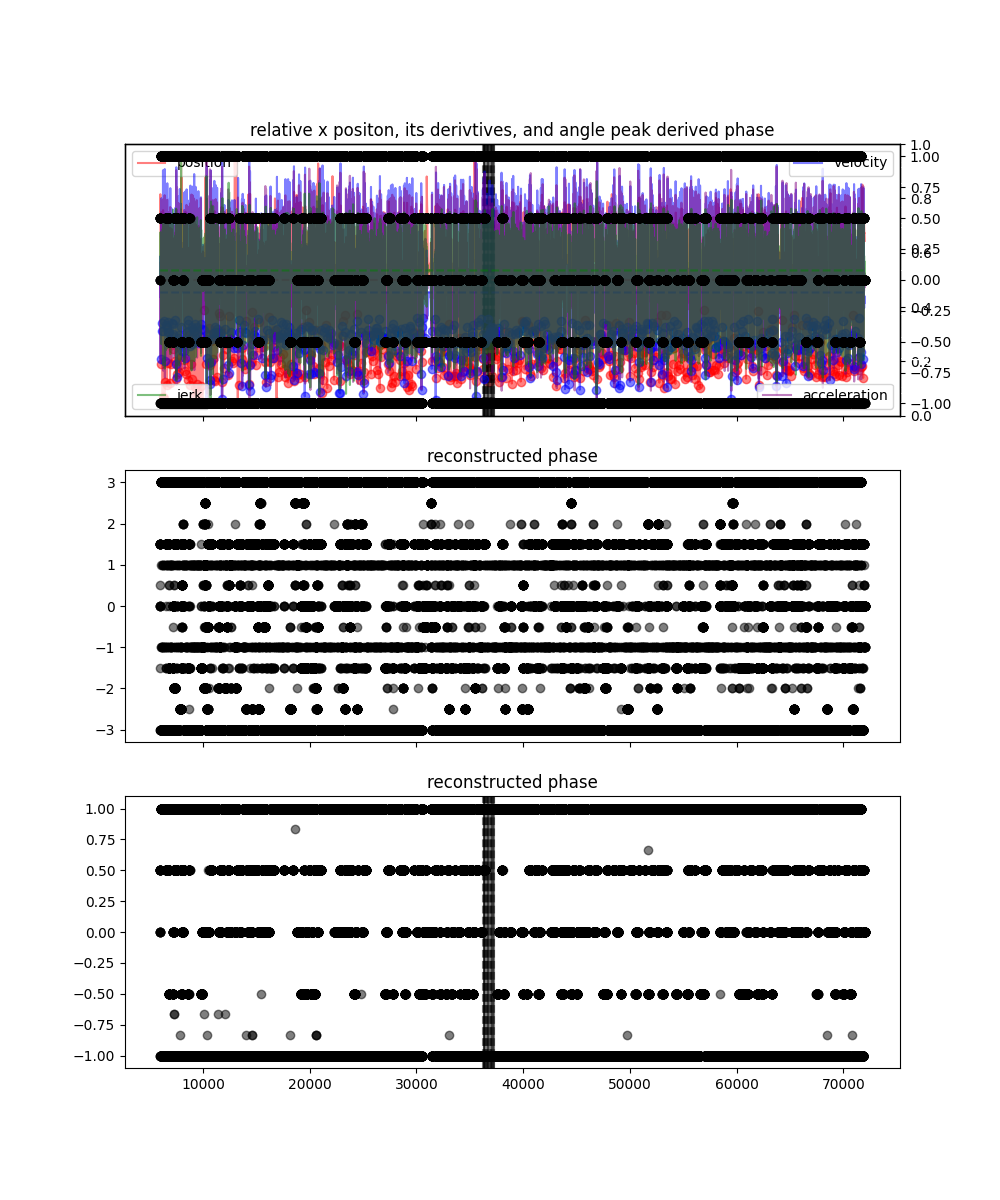

In [149]:
figq, (ax0, ax3, ax4) = plt.subplots(3, 1, figsize=(10,12),sharex = True)

# ax22 = ax2.twinx()    
# ax222 = ax2.twinx()    
# ax2222 = ax2.twinx()    
# ax222222 = ax2.twinx()    
# ax2.plot(fnum, fore_angle, c = 'r', alpha = 0.5, label= 'position')
# ax2.scatter(fnum[peaks_theta], fore_angle[peaks_theta], c = 'r', alpha = 0.5)
# ax22.plot(fnum, dthetadt, c = 'b', alpha = 0.5,label = 'velocity')
# ax22.scatter(fnum[peaks_dthetadt_plus], dthetadt[peaks_dthetadt_plus], c = 'b', alpha = 0.5)
# ax22.scatter(fnum[peaks_dthetadt_minus], dthetadt[peaks_dthetadt_minus], c = 'b', alpha = 0.5)
# ax22.plot(fnum, np.zeros(dthetadt.shape[0])+20, c = 'b', alpha = 0.5, linestyle = '--')
# ax2222.plot(fnum, ddthetaddt, c = 'purple', alpha = 0.5, label = 'acceleration')
# ax2222.scatter(fnum[peaks_ddthetaddt_plus], ddthetaddt[peaks_ddthetaddt_plus], c = 'purple', alpha = 0.5)
# ax2222.scatter(fnum[peaks_ddthetaddt_minus], ddthetaddt[peaks_ddthetaddt_minus], c = 'purple', alpha = 0.5)
# ax2222.plot(fnum, np.zeros(ddthetaddt.shape[0]), c = 'purple', alpha = 0.5, linestyle = '--')
# # ax22222.plot(fnum, dddthetadddt, c = 'green', alpha = 0.5, label = 'jerk')
# # ax22222.scatter(fnum[peaks_dddthetadddt_minus], dddthetadddt[peaks_dddthetadddt_minus], c = 'green', alpha = 0.5)
# # ax22222.plot(fnum, np.zeros(dddthetadddt.shape[0]), c = 'green', linestyle = '--', alpha = 0.5)
# ax2.legend(loc='upper left')
# ax22.legend(loc='upper right')
# ax2222.legend(loc='lower right')
# # ax22222.legend(loc='lower left')
# ax2.tick_params(axis='y', colors='white')
# ax22.tick_params(axis='y', colors='white')
# ax2222.tick_params(axis='y', colors='white')
# # ax22222.tick_params(axis='y', colors='white')
# ax2.set_title("forelimb angle, its derivtives, and angle peak derived phase")
# ax222222.scatter(fnum, insanity_check, c = 'k', alpha = 0.5)



ax00 = ax0.twinx()    
ax000 = ax0.twinx()    
ax0000 = ax0.twinx()    
ax00000 = ax0.twinx()  
ax000000 = ax0.twinx()
ax0.plot(fnum, rel_x, c = 'r', alpha = 0.5, label= 'position')
# ax0.scatter(fnum[peaks_relx], rel_x[peaks_relx], c = 'r', alpha = 0.5)
ax0.scatter(fnum[neg_peaks_relx], rel_x[neg_peaks_relx], c = 'r', alpha = 0.5)

ax00.plot(fnum, dxdt, c = 'b', alpha = 0.5, label = 'velocity')
ax0000.plot(fnum, ddxddt, c = 'purple', alpha = 0.5, label = 'acceleration')
ax00000.plot(fnum, dddxdddt, c = 'green', alpha = 0.5, label = 'jerk')
ax0.legend(loc='upper left')
ax00.plot(fnum, np.zeros(dxdt.shape[0])+20, c = 'b', alpha = 0.5, linestyle = '--')
ax0000.plot(fnum, np.zeros(ddxddt.shape[0]), c = 'purple', alpha = 0.5, linestyle = '--')
ax00000.plot(fnum, np.zeros(dddxdddt.shape[0]), c = 'green', linestyle = '--', alpha = 0.5)
# ax00.scatter(fnum[peaks_dxdt_plus], dxdt[peaks_dxdt_plus], c = 'b', alpha = 0.5)
ax00.scatter(fnum[peaks_dxdt_minus], dxdt[peaks_dxdt_minus], c = 'b', alpha = 0.5)
# ax0000.scatter(fnum[peaks_ddxddt_plus], ddxddt[peaks_ddxddt_plus], c = 'purple', alpha = 0.5)
# ax0000.scatter(fnum[peaks_ddxddt_minus], ddxddt[peaks_ddxddt_minus], c = 'purple', alpha = 0.5)
# ax00000.scatter(fnum[peaks_dddxdddt_minus], dddxdddt[peaks_dddxdddt_minus], c = 'green', alpha = 0.5)
ax000000.scatter(fnum, wrist_phase, c = 'k', alpha = 0.5)

ax00.legend(loc='upper right')
ax0000.legend(loc='lower right')
ax00000.legend(loc='lower left')
ax0.tick_params(axis='y', colors='white')
ax00.tick_params(axis='y', colors='white')
ax0000.tick_params(axis='y', colors='white')
ax00000.tick_params(axis='y', colors='white')
ax0.set_title("relative x positon, its derivtives, and angle peak derived phase")



# ax11 = ax1.twinx()    
# ax111 = ax1.twinx()    
# ax1111 = ax1.twinx()    
# ax11111 = ax1.twinx()    
# ax111111 = ax1.twinx()    

# ax1.plot(fnum, rel_y, c = 'r', alpha = 0.5, label= 'position')
# ax1.scatter(fnum[peaks_rely], rel_y[peaks_rely], c = 'r', alpha = 0.5)
# ax11.plot(fnum, dydt, c = 'b', alpha = 0.5, label = 'velocity')
# ax1111.plot(fnum, ddyddt, c = 'purple', alpha = 0.5, label = 'acceleration')
# ax11111.plot(fnum, dddydddt, c = 'green', alpha = 0.5, label = 'jerk')
# ax1.legend(loc='upper left')
# ax11.plot(fnum, np.zeros(dydt.shape[0])+20, c = 'b', alpha = 0.5, linestyle = '--')
# ax1111.plot(fnum, np.zeros(ddyddt.shape[0]), c = 'purple', alpha = 0.5, linestyle = '--')
# ax11111.plot(fnum, np.zeros(dddydddt.shape[0]), c = 'green', linestyle = '--', alpha = 0.5)
# # ax11.scatter(fnum[peaks_dydt_plus], dydt[peaks_dydt_plus], c = 'b', alpha = 0.5)
# ax11.scatter(fnum[peaks_dydt_minus], dydt[peaks_dydt_minus], c = 'b', alpha = 0.5)
# ax1111.scatter(fnum[peaks_ddyddt_plus], ddyddt[peaks_ddyddt_plus], c = 'purple', alpha = 0.5)
# ax1111.scatter(fnum[peaks_ddyddt_minus], ddyddt[peaks_ddyddt_minus], c = 'purple', alpha = 0.5)
# ax11111.scatter(fnum[peaks_dddydddt_minus], dddydddt[peaks_dddydddt_minus], c = 'green', alpha = 0.5)
# ax11.legend(loc='upper right')
# ax1111.legend(loc='lower right')
# ax11111.legend(loc='lower left')
# ax1.tick_params(axis='y', colors='white')
# ax11.tick_params(axis='y', colors='white')
# ax1111.tick_params(axis='y', colors='white')
# ax11111.tick_params(axis='y', colors='white')
# ax1.set_title("relative y positon, its derivtives, and angle peak derived phase")
# ax111111.scatter(fnum, y_swing, c = 'k', alpha = 0.5)


   
# ax4.scatter(fnum, stance_test, c = 'r', alpha = 0.5)
# ax4.scatter(fnum, swing_test, c = 'b', alpha = 0.5)

ax3.scatter(fnum, sum_phase_tmp, c = 'k', alpha = 0.5)
ax3.tick_params(axis='y', colors='black')
ax3.set_title("reconstructed phase")
# ax4.scatter(fnum, finger_phase, c = 'b', alpha = 0.5)
# ax4.scatter(fnum, wrist_phase, c = 'g', alpha = 0.5)
# ax4.scatter(fnum, knuckle_phase, c = 'r', alpha = 0.5)
ax4.scatter(fnum, sum_phase, c = 'k', alpha = 0.5)
ax4.tick_params(axis='y', colors='black')
ax4.set_title("reconstructed phase")

# ax2.axvline(x = 36230 , c = 'k', alpha = 0.5, linestyle = '--')
# ax2.axvline(x = 36317 , c = 'k', alpha = 0.5, linestyle = '--')
# ax2.axvline(x = 36397 , c = 'k', alpha = 0.5, linestyle = '--')
# ax2.axvline(x = 36506 , c = 'k', alpha = 0.5, linestyle = '--')
# ax2.axvline(x = 36619 , c = 'k', alpha = 0.5, linestyle = '--')
# ax2.axvline(x = 36737 , c = 'k', alpha = 0.5, linestyle = '--')
# ax2.axvline(x = 36867 , c = 'k', alpha = 0.5, linestyle = '--')
# ax2.axvline(x = 36986 , c = 'k', alpha = 0.5, linestyle = '--')
# ax2.axvline(x = 37114 , c = 'k', alpha = 0.5, linestyle = '--')
# ax2.axvline(x = 37235 , c = 'k', alpha = 0.5, linestyle = '--')
# ax2.axvline(x = 36284 , c = 'k', alpha = 0.5)
# ax2.axvline(x = 36363 , c = 'k', alpha = 0.5)
# ax2.axvline(x = 36469 , c = 'k', alpha = 0.5)
# ax2.axvline(x = 36587 , c = 'k', alpha = 0.5)
# ax2.axvline(x = 36695 , c = 'k', alpha = 0.5)
# ax2.axvline(x = 36829 , c = 'k', alpha = 0.5)
# ax2.axvline(x = 36949 , c = 'k', alpha = 0.5)
# ax2.axvline(x = 37082 , c = 'k', alpha = 0.5)
# ax2.axvline(x = 37200 , c = 'k', alpha = 0.5)
# ax2.axvline(x = 37306 , c = 'k', alpha = 0.5)

ax0.axvline(x = 36230 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36317 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36397 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36506 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36619 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36737 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36867 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36986 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 37114 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 37235 , c = 'k', alpha = 0.5, linestyle = '--')
ax0.axvline(x = 36284 , c = 'k', alpha = 0.5)
ax0.axvline(x = 36363 , c = 'k', alpha = 0.5)
ax0.axvline(x = 36469 , c = 'k', alpha = 0.5)
ax0.axvline(x = 36587 , c = 'k', alpha = 0.5)
ax0.axvline(x = 36695 , c = 'k', alpha = 0.5)
ax0.axvline(x = 36829 , c = 'k', alpha = 0.5)
ax0.axvline(x = 36949 , c = 'k', alpha = 0.5)
ax0.axvline(x = 37082 , c = 'k', alpha = 0.5)
ax0.axvline(x = 37200 , c = 'k', alpha = 0.5)
ax0.axvline(x = 37306 , c = 'k', alpha = 0.5)

# ax1.axvline(x = 36230 , c = 'k', alpha = 0.5, linestyle = '--')
# ax1.axvline(x = 36317 , c = 'k', alpha = 0.5, linestyle = '--')
# ax1.axvline(x = 36397 , c = 'k', alpha = 0.5, linestyle = '--')
# ax1.axvline(x = 36506 , c = 'k', alpha = 0.5, linestyle = '--')
# ax1.axvline(x = 36619 , c = 'k', alpha = 0.5, linestyle = '--')
# ax1.axvline(x = 36737 , c = 'k', alpha = 0.5, linestyle = '--')
# ax1.axvline(x = 36867 , c = 'k', alpha = 0.5, linestyle = '--')
# ax1.axvline(x = 36986 , c = 'k', alpha = 0.5, linestyle = '--')
# ax1.axvline(x = 37114 , c = 'k', alpha = 0.5, linestyle = '--')
# ax1.axvline(x = 37235 , c = 'k', alpha = 0.5, linestyle = '--')
# ax1.axvline(x = 36284 , c = 'k', alpha = 0.5)
# ax1.axvline(x = 36363 , c = 'k', alpha = 0.5)
# ax1.axvline(x = 36469 , c = 'k', alpha = 0.5)
# ax1.axvline(x = 36587 , c = 'k', alpha = 0.5)
# ax1.axvline(x = 36695 , c = 'k', alpha = 0.5)
# ax1.axvline(x = 36829 , c = 'k', alpha = 0.5)
# ax1.axvline(x = 36949 , c = 'k', alpha = 0.5)
# ax1.axvline(x = 37082 , c = 'k', alpha = 0.5)
# ax1.axvline(x = 37200 , c = 'k', alpha = 0.5)
# ax1.axvline(x = 37306 , c = 'k', alpha = 0.5)

ax4.axvline(x = 36230 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36317 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36397 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36506 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36619 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36737 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36867 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36986 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 37114 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 37235 , c = 'k', alpha = 0.5, linestyle = '--')
ax4.axvline(x = 36284 , c = 'k', alpha = 0.5)
ax4.axvline(x = 36363 , c = 'k', alpha = 0.5)
ax4.axvline(x = 36469 , c = 'k', alpha = 0.5)
ax4.axvline(x = 36587 , c = 'k', alpha = 0.5)
ax4.axvline(x = 36695 , c = 'k', alpha = 0.5)
ax4.axvline(x = 36829 , c = 'k', alpha = 0.5)
ax4.axvline(x = 36949 , c = 'k', alpha = 0.5)
ax4.axvline(x = 37082 , c = 'k', alpha = 0.5)
ax4.axvline(x = 37200 , c = 'k', alpha = 0.5)
ax4.axvline(x = 37306 , c = 'k', alpha = 0.5)